In [14]:
#import statements
import numpy as np 
from numpy import mean, absolute
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
import os

In [ ]:
#Read source data information file
f = open('Qualitative_Bankruptcy_files/Qualitative_Bankruptcy.info.txt', encoding='latin-1')
print(f.read())

In [15]:
#Read source data
cols = ['IR','MR','FF','CR','CO','OP','CLASS']
data = []

f = open('Qualitative_Bankruptcy_files/Qualitative_Bankruptcy.data.txt', encoding='latin-1')
for i, line in enumerate(f):
    data.append(line.replace('\n','').split(','))

df = pd.DataFrame(data, columns = cols)


## Return a count of unique values in each column

In [13]:
df.nunique()

Industrial Risk          3
Management Risk          3
Operating Risk           3
Financial Flexibility    3
Credibility              3
Competitiveness          3
Class                    2
dtype: int64

In [26]:
#check for missing values
df[df.isna().any(axis=1)]

,IR,MR,FF,CR,CO,OP,CLASS


## Determine whether class is equally weighted

In [27]:
N = df['CLASS'].count()

dfClassWeight = pd.DataFrame({'#': df.groupby('CLASS')['CLASS'].count(),
                            '%': (df.groupby('CLASS')['CLASS'].count()/N)*100})

dfClassWeight


,#,%
CLASS,,
B,107,42.8
NB,143,57.2


In [28]:
lowerBound = .4
if min(dfClassWeight['%'])<lowerBound:
    print("Partition w/Oversample")
else:
    print("Standard Partition")

Standard Partition


## Partition the dataset

In [31]:
cols = list(df.columns)
target_col = 'CLASS'
X_cols = cols[:-1]

X=pd.get_dummies(df[X_cols], drop_first=True) #Use one hot encoding on qualitative variables

y=df[target_col]
#encode the classes
le = preprocessing.LabelEncoder()
le.fit(y)
y=le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.6, random_state=12345)


In [32]:
data = {'Training': [len(X_train), len(X_train)/N],
        'Validation': [len(X_test), len(X_test)/N]}

dfPartitionValidation = pd.DataFrame.from_dict(data, orient='index', columns=['# Records', '% Records'])
dfPartitionValidation

,# Records,% Records
Training,150,0.6
Validation,100,0.4


In [33]:
clf = DecisionTreeClassifier(random_state=0,criterion='gini', max_leaf_nodes=30, max_depth=10,min_samples_leaf=2)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
1-accuracy_score(y_test, pred)
#maxDepthList.append(1)
#minSamplesLeafList.append(2)
#maxLeafNodes.append(2)


0.010000000000000009

In [34]:
pd.DataFrame(
    confusion_matrix(y_test, pred),
    columns=['B', 'NB'],
    index=['True B', 'True NB']
)

,B,NB
True B,47,0
True NB,1,52


## Create a pruned classification tree
## This model is set to maximize accuracy but it might make sense in this case to optimize for false positives over false negatives since predicting a bank will not be bankrupt when it actually is poses a greater risk.

In [35]:
def lowest_error(X_train, X_test, y_train, y_test, max_depth=30,min_samples_leaf=30,max_leaf_nodes=30):
    """Prune model by testing values of max depth, min samples leaf and max leaf nodes. Return the model
    with the least complexity and lowest mean squared error"""
    errorList = []
    maxDepthList = []
    minSamplesLeafList = []
    maxLeafNodes = []
    for i in range(1,max_depth):
        for j in range(2,min_samples_leaf):
            for k in range(2,max_leaf_nodes):
                clf = DecisionTreeClassifier(random_state=0,criterion='gini',max_depth=i, min_samples_leaf=j, max_leaf_nodes=k)
                clf.fit(X_train, y_train)
                pred = clf.predict(X_test)
                errorList.append(1-accuracy_score(y_test, pred))
                maxDepthList.append(i)
                minSamplesLeafList.append(j)
                maxLeafNodes.append(k)
                #print(error, i, j, k)
    dfModels = pd.DataFrame({'error': pd.Series(errorList),
                    'max depth': pd.Series(maxDepthList),
                    'min samples leaf': pd.Series(minSamplesLeafList),
                    'max leaf nodes': pd.Series(maxLeafNodes)})
    #sort the dataframe by mse and complexity
    dfModels = dfModels.sort_values(by=['error','max leaf nodes','min samples leaf', 'max depth']).reset_index()
    #return the pruned model
    prunedTree = DecisionTreeClassifier(random_state=0,criterion='gini',max_depth=dfModels['max depth'][0], min_samples_leaf=dfModels['min samples leaf'][0], max_leaf_nodes=dfModels['max leaf nodes'][0])
    prunedTree.fit(X_train, y_train)
    return prunedTree

In [36]:
prunedTree = lowest_error(X_train, X_test, y_train, y_test,max_leaf_nodes=30, max_depth=10,min_samples_leaf=3)

## Plot the pruned tree

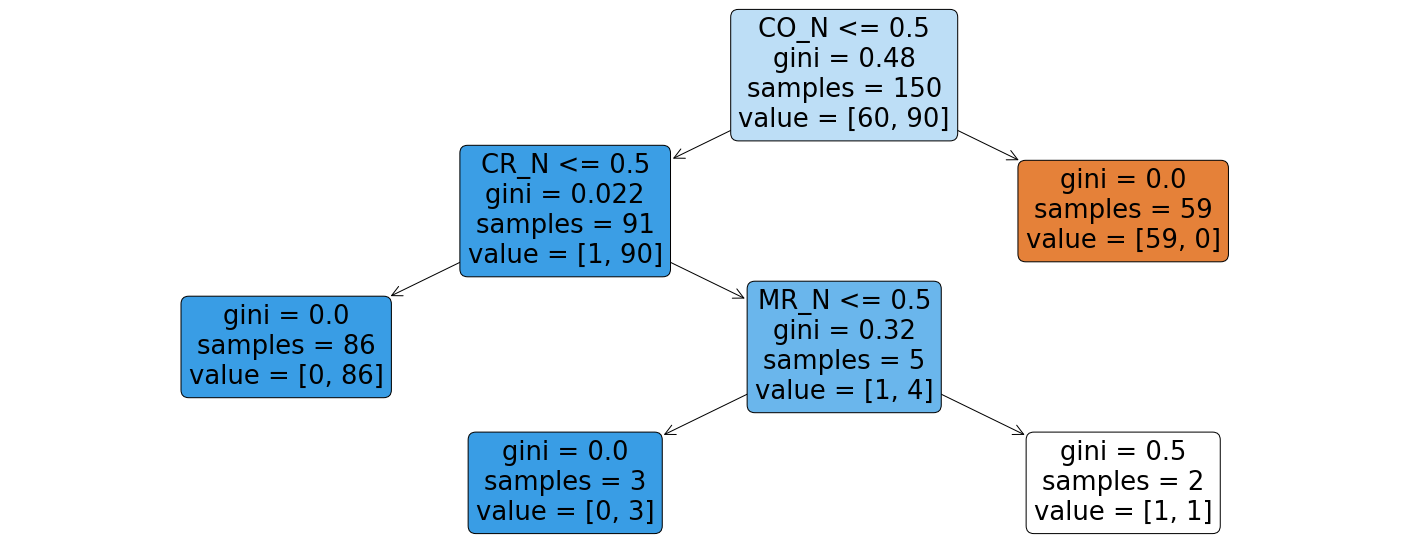

In [37]:
plt.figure(figsize=(25,10))
a = tree.plot_tree(prunedTree,
                    feature_names = list(X.columns),
                    filled = True,
                    rounded = True)

## Confusion Matrix for Training and Validation

In [38]:
dfTraining = pd.DataFrame(
    confusion_matrix(y_train, prunedTree.predict(X_train)),
    columns=['B', 'NB'],
    index=['True B', 'True NB'])

dfTraining

,B,NB
True B,60,0
True NB,1,89


In [39]:
dfValidation = pd.DataFrame(
    confusion_matrix(y_test, prunedTree.predict(X_test)),
    columns=['B', 'NB'],
    index=['True B', 'True NB'])

dfValidation

,B,NB
True B,47,0
True NB,1,52


Confusion Matrix: Training
[[1.   0.  ]
 [0.01 0.99]]
Confusion Matrix: Validation
[[1.   0.  ]
 [0.02 0.98]]


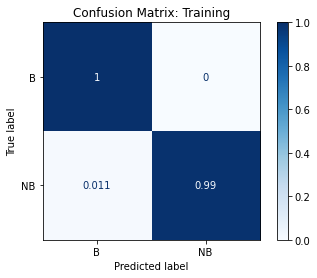

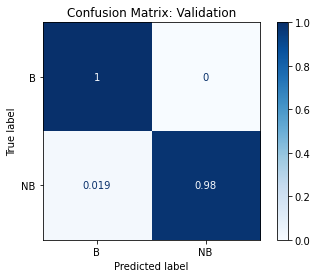

In [40]:
np.set_printoptions(precision=2)

titles_options = [("Confusion Matrix: Training", X_train, y_train),
                ("Confusion Matrix: Validation", X_test, y_test)]

for title, X, y in titles_options:
    disp = plot_confusion_matrix(prunedTree, X, y, 
                                display_labels = ['B','NB'],
                                cmap=plt.cm.Blues,
                                normalize='true')
    disp.ax_.set_title(title)
    
    print(title)
    print(disp.confusion_matrix)

plt.show()

## Metrics

In [41]:
def chance(actual, pred):
    """function to calculate P(Chance) given the array of actual and predicted values and the total number of samples"""
    tn, fp, fn, tp = confusion_matrix(actual, pred).ravel()
    n = tn+fp+fn+tp
    c=((tn+fp)/n)*((tn+fn)/n)+((fn+tp)/n)*((fp+tp)/n)
    return c

In [42]:
predTrain = prunedTree.predict(X_train)
predTest = prunedTree.predict(X_test)

data = {'Accuracy': [accuracy_score(y_train, predTrain),accuracy_score(y_test, predTest)],
        'Error': [1-accuracy_score(y_train, predTrain),1-accuracy_score(y_test, predTest)],
        'P(Agreement)': [accuracy_score(y_train, predTrain),accuracy_score(y_test, predTest)],
        'P(Chance)': [chance(y_train, predTrain), chance(y_test, predTest)],
        'Kappa': [(accuracy_score(y_train, predTrain)-chance(y_train, predTrain))/(1-chance(y_train, predTrain)),(accuracy_score(y_test, predTest)-chance(y_test, predTest))/(1-chance(y_test, predTest))]
        }

dfSummary = pd.DataFrame.from_dict(data, orient='index', columns=['Training', 'Validation'])
dfSummary['%Difference'] = (dfSummary['Training']-dfSummary['Validation'])/dfSummary['Training']*100
dfSummary

,Training,Validation,%Difference
Accuracy,0.993333,0.990000,0.335570
Error,0.006667,0.010000,-50.000000
P(Agreement),0.993333,0.990000,0.335570
P(Chance),0.518667,0.501200,3.367609
Kappa,0.986150,0.979952,0.628475


## Feature Importance

In [43]:
dfFeatures = pd.DataFrame(zip(X.columns, prunedTree.feature_importances_),columns=['Feature','Importance'])
dfFeatures['Importance'] = dfFeatures['Importance'].replace(0, np.nan)
dfFeatures['Rank'] = dfFeatures['Importance'].rank(method='max', ascending=False)
dfFeatures

,Feature,Importance,Rank
0,IR_N,NaN,NaN
1,IR_P,NaN,NaN
2,MR_N,0.008451,2.0
3,MR_P,NaN,NaN
4,FF_N,NaN,NaN
5,FF_P,NaN,NaN
6,CR_N,0.005324,3.0
7,CR_P,NaN,NaN
8,CO_N,0.986225,1.0
9,CO_P,NaN,NaN
